## 0.importing pytorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

device="cuda" if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1.Get Data

In [2]:
import os
import requests
import zipfile
from pathlib import Path
data_path=Path('data/')

image_path=data_path /'pizza_steak_sushi'


if image_path.is_dir():
    print(f'{image_path} directory is already exist')
else:
    print(f'{image_path} does not exists...creating one')
    image_path.mkdir(parents=True,exist_ok=True)
    
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading Data....")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
    print('unzipping data')
    zip_ref.extractall(image_path)

os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory is already exist
unzipping data


In [3]:
import os
def walk_through_dir(dir_path):
    '''walk through dir_path returning its contents'''
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)}  directories and {len(filenames)} images in '{dirpath}' .")

In [4]:
walk_through_dir(image_path)

There are 2  directories and 0 images in 'data\pizza_steak_sushi' .
There are 3  directories and 0 images in 'data\pizza_steak_sushi\test' .
There are 0  directories and 25 images in 'data\pizza_steak_sushi\test\pizza' .
There are 0  directories and 19 images in 'data\pizza_steak_sushi\test\steak' .
There are 0  directories and 31 images in 'data\pizza_steak_sushi\test\sushi' .
There are 3  directories and 0 images in 'data\pizza_steak_sushi\train' .
There are 0  directories and 78 images in 'data\pizza_steak_sushi\train\pizza' .
There are 0  directories and 75 images in 'data\pizza_steak_sushi\train\steak' .
There are 0  directories and 72 images in 'data\pizza_steak_sushi\train\sushi' .


In [5]:
train_dir=image_path / 'train'
test_dir=image_path / 'test'

In [6]:
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [7]:
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.ToTensor()
    ])

In [8]:
train_data=datasets.ImageFolder(root=train_dir,transform=transform)
train_data_org=datasets.ImageFolder(root=train_dir)
test_data=datasets.ImageFolder(root=test_dir,transform=transform)
train_dataloader=DataLoader(dataset=train_data,batch_size=1,shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=1,shuffle=False)

## 2.1 Visualizing and image
1. Get all of the image pathes
2. Pick a random image path using Pythons random.choice()
3. Get the image class names using `pathlib.Path.parent.stem`
4. Since we're working with images , let's open the image with Pythons pil
5. well then show the image  and print metadata
6. 

In [9]:
image_path

WindowsPath('data/pizza_steak_sushi')

pizza
Image height:384 Image width:512


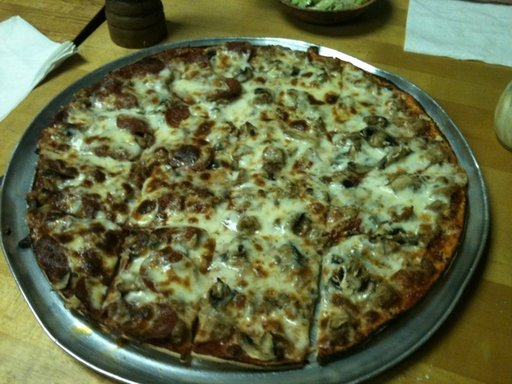

In [ ]:
import random
from PIL import Image 


image_path_list=list(image_path.glob('*/*/*.jpg'))

random_image_path=random.choice(image_path_list)

image_class=random_image_path.parent.stem
print(image_class)
image=Image.open(random_image_path)
print(f"Image height:{image.height} Image width:{image.width}")
image

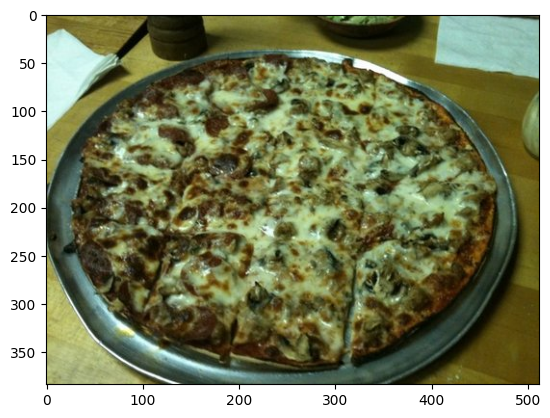

In [11]:
import matplotlib.pyplot as plt
import numpy as np
img_as_array=np.asarray(image)

plt.imshow(img_as_array)

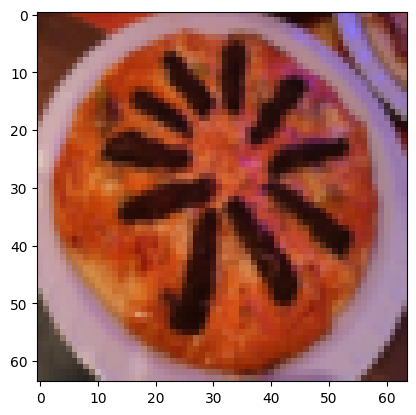

In [12]:
label,img=next(enumerate(train_dataloader))
plt.imshow(np.transpose(img[0][0],(1,2,0)))

In [13]:
class_names=train_data.classes
def ImageShow(img,label):
    plt.title(class_names[label])
    plt.imshow(np.transpose(img,(1,2,0)))

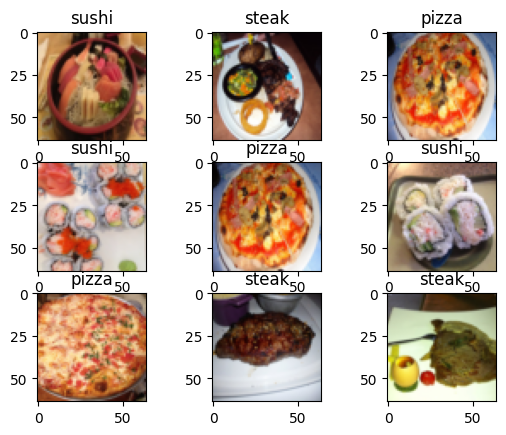

In [14]:
for i in range(0,9):
    plt.subplot(3,3,i+1)
    random_idx=torch.randint(0,len(train_data),size=[1]).item()
    img,lab=train_data[random_idx]
    ImageShow(img,lab)

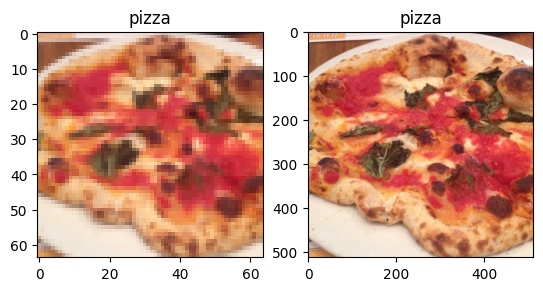

In [15]:
random_idx=torch.randint(0,len(train_data),size=[1]).item()
img,lab=train_data[random_idx]
img2,lab2=train_data_org[random_idx]
plt.subplot(1,2,1)
ImageShow(img,lab)
plt.subplot(1,2,2)
ImageShow(np.transpose(img2,(2,0,1)),lab2)

In [18]:
def find_classes(directory:str) -> Tuple[List[str],Dict[str,int]]:
    '''Finds the class folder names in a target directory'''
    classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Could't find any class in {directory}... please check file structure")
        
        
    class_to_idx={class_name: i for i ,class_name in enumerate(classes)}
    return classes , class_to_idx


## Loading image data with a custome `Dataset`
1. want to be able load images from file
2. want to be able to get class names from the dataset
3. want to be able to get classes as dictionary  from the Dataset

Pros:
* can create a `Dataset ` out almost anything
* Not limited to Pytorch pre-built `Dataset` functions
Cons:
* Even though you could create `Dataset` out of almost anything , it does not mean it will work...
* using a custom `Dataset` often result in us writing more code wich could be prone to errors or performance issues.

All custom datasets in pytorch often subclass ///

In [19]:
import os 
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

## create a custom `Dataset` to replicate `ImageFolder`
1. subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory
3. Create several attributes:
   * paths - paths of or images
   * transform - the transform we'd like to use
   * classes - a list of the target classes
   * class_to_idx - a dict of the target classes maped to integer labels
4. Create a function to `load_images()` , this function will open an image
5. overwrite the `_len()_` method
6. overwrite the `_getitem()_` method to return a given sample when passed an index


In [20]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self,targ_dir:str,transform=None):

        self.paths=list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        self.transform=transform
        self.classes,self.class_to_idx=find_classes(targ_dir)
    def load_image(self,index:int) -> Image.Image:
        """Open an image via a path and return it."""
        image_path=self.paths[index]

        return Image.open(image_path)
        
        
    def __len__(self) -> int:
        "Returns the total number of samples"
        return len(self.paths)
    def __getitem__(self,index:int) -> Tuple[torch.Tensor,int]:#image,label=train_data[0]
        "Returns one sample of data , data and label (X,y)."
        img=self.load_image(index)
        class_name=self.paths[index].parent.name # expect path in format: data_folder/class_name/image.jpg
        class_idx=self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img),class_idx
        else :
            return img,class_idx
        

In [21]:
train_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.ToTensor()
    ])
test_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
    ])

In [22]:
train_data_custom=ImageFolderCustom(targ_dir=train_dir,transform=train_transform)
test_data_custom=ImageFolderCustom(targ_dir=test_dir,transform=test_transform)

In [23]:
len(train_data_custom)

225

In [24]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

## Create a function to display random images

In [29]:
def display_random_imnages(dataset:torch.utils.data.dataset,
                          classes:list[str]=None,
                          n:int=10,
                          display_shape:bool=True,
                          seed:int=None):
    if n>10:
        n=10
        display_shape=False
        print(f"For display , purposes , n should't be larger then 10 ")
    if seed:
        random.seed(seed)
    random_samples_idx=  random.sample(range(len(dataset)),k=n)

    plt.figure(figsize=(16,8))
    
    for i , targ_sample in enumerate(random_samples_idx):
        targ_image,targ_label=dataset[targ_sample][0],dataset[targ_sample][1]

        targ_image_adjust=np.transpose(targ_image,(1,2,0))

        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title=f"class : {classes[targ_label]}"
            if display_shape:
                title=title+f"\nshape: {targ_image_adjust.shape}"
            plt.title(title)     
            

    

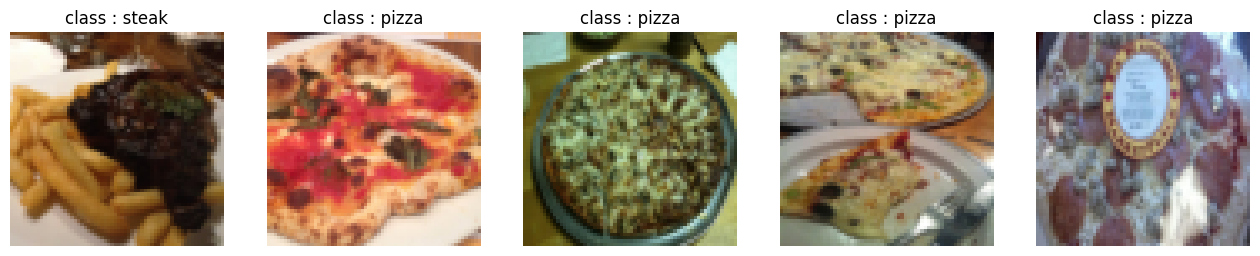

In [37]:
display_random_imnages(dataset=train_data,classes=class_names,n=5,display_shape=False)

In [38]:
from torch.utils.data import DataLoader
train_dataloader_custom=DataLoader(dataset=train_data_custom,batch_size=32,num_workers=0,shuffle=True)
test_dataloader_custom=DataLoader(dataset=test_data_custom,batch_size=32,num_workers=0,shuffle=False)


In [69]:
train_transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

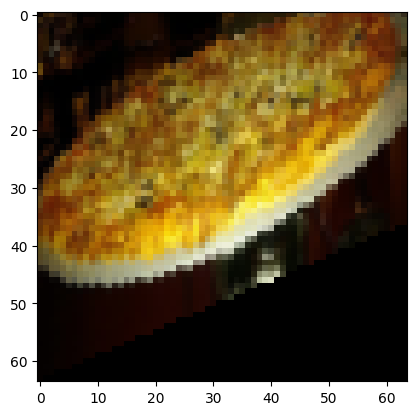

In [78]:
img=Image.open(image_path_list[0])
plt.imshow(np.transpose(train_transform(img),(1,2,0)))#every time is new transport happend for image

In [79]:
simple_transport=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [81]:
train_data_simple=datasets.ImageFolder(root=train_dir,transform=simple_transport)
test_data_simple=datasets.ImageFolder(root=test_dir,transform=simple_transport)
BATCH_SIZE=32
NUM_WORKER=os.cpu_count()
train_dataloader_simple=DataLoader(dataset=train_data_simple,batch_size=BATCH_SIZE,num_workers=NUM_WORKER,shuffle=True)
test_dataloader_simple=DataLoader(dataset=test_data_simple,batch_size=BATCH_SIZE,num_workers=NUM_WORKER,shuffle=True)